In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import torch
import os
from pathlib import Path
from omegaconf import OmegaConf

from cell_similarity.data.datasets import EmbeddingDataset
from cell_similarity.model import LinearProjection
from cell_similarity.data import make_dataloaders

/home/guevel/OT4D/dinov2/dinov2/layers/swiglu_ffn.py:43: UserWarning: xFormers is available (SwiGLU)
  warnings.warn("xFormers is available (SwiGLU)")
/home/guevel/OT4D/dinov2/dinov2/layers/attention.py:27: UserWarning: xFormers is available (Attention)
  warnings.warn("xFormers is available (Attention)")
/home/guevel/OT4D/dinov2/dinov2/layers/block.py:33: UserWarning: xFormers is available (Block)
  warnings.warn("xFormers is available (Block)")


## Load data 

In [11]:
device = "cuda" if torch.cuda.is_available() else "cpu"

embeddings_path = "/home/guevel/OT4D/cell_similarity/projection/cache"
datasets = {state: EmbeddingDataset(Path(embeddings_path) / state) for state in os.listdir(embeddings_path)}
dataloaders = make_dataloaders(datasets, batch_size=64, num_workers=4)

In [12]:
from cell_similarity.configs import default_config

cfg_path = "/home/guevel/OT4D/cell_similarity/src/cell_similarity/configs/config_large.yaml"
default_cfg = OmegaConf.create(default_config)
cfg = OmegaConf.load(cfg_path)
cfg = OmegaConf.merge(cfg, default_cfg)

## Make model

In [13]:
embed_dim = datasets["train"][0][0].shape[0]
num_classes = len(os.listdir(cfg.preprocess.dataset_path))

kwargs = cfg.model
model = LinearProjection(embedding_size=embed_dim, num_classes=num_classes, **kwargs)

model = model.to(device)
model.train()

LinearProjection(
  (model): Sequential(
    (0): Linear(in_features=1024, out_features=1024, bias=True)
    (1): LayerNorm((1024,), eps=1e-05, elementwise_affine=True)
    (2): ReLU()
    (3): Linear(in_features=1024, out_features=13, bias=True)
  )
)

In [14]:
for i in dataloaders["train"]:
    break

## Train

In [15]:
import lightning as L
from lightning.pytorch.callbacks import ModelCheckpoint, EarlyStopping

checkpoint_callback = ModelCheckpoint(dirpath=cfg.train.output_dir, monitor="val_loss", save_top_k=1, save_last=True)
early_stopping = EarlyStopping("val_loss", patience=20)
trainer = L.Trainer(max_epochs=cfg.train.max_epochs, callbacks=[checkpoint_callback, early_stopping], accelerator=device)

/home/guevel/.conda/envs/cell_sim/lib/python3.10/site-packages/lightning/fabric/plugins/environments/slurm.py:204: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /home/guevel/.local/lib/python3.10/site-packages/ipy ...
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/home/guevel/.conda/envs/cell_sim/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/logger_connector/logger_connector.py:75: Starting from v1.9.0, `tensorboardX` has been removed as a dependency of the `lightning.pytorch` package, due to potential conflicts with other packages in the ML ecosystem. For this reason, `logger=True` will use `CSVLogger` as the default logger, unless the `tensorboard` or `tensorboardX` packages are found. Please `pip install lightning[extra]` or one

In [16]:
trainer.fit(model=model, train_dataloaders=dataloaders["train"], val_dataloaders=dataloaders["validation"])

/home/guevel/.conda/envs/cell_sim/lib/python3.10/site-packages/lightning/pytorch/callbacks/model_checkpoint.py:653: Checkpoint directory /home/guevel/OT4D/cell_similarity/projection/model exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name  | Type       | Params
-------------------------------------
0 | model | Sequential | 1.1 M 
-------------------------------------
1.1 M     Trainable params
0         Non-trainable params
1.1 M     Total params
4.260     Total estimated model params size (MB)


Sanity Checking: |                                                                                            …

Training: |                                                                                                   …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

> The training doesn't seems to work very well -> issue with the data or the code ?

In [21]:
from sklearn.metrics import classification_report

def evaluate(model, dataloader, target_names=None):
    predictions = []
    true_labels = []
    model.eval()

    for batch, labels in dataloader:
        with torch.no_grad():
            logits = model(batch)

        _, preds = torch.max(logits, 1)
        predictions.extend(preds)
        true_labels.extend(labels)

    print(classification_report(true_labels, predictions, target_names=target_names))

In [22]:
root = cfg.preprocess.dataset_path
target_dict = {k: i for i, k in enumerate(os.listdir(root))}

evaluate(model, dataloaders["test"], target_names=target_dict.keys())

                      precision    recall  f1-score   support

        promyelocyte       0.49      0.47      0.48        59
          lymphocyte       0.90      0.46      0.61       121
       metamyelocyte       0.36      0.50      0.42       102
            monocyte       0.79      0.79      0.79       142
            basophil       0.56      0.80      0.66       122
          eosinophil       0.95      0.98      0.96       312
segmented_neutrophil       0.60      0.79      0.68       165
          neutrophil       0.62      1.00      0.77         5
        erythroblast       0.84      0.92      0.88       155
            platelet       0.99      0.99      0.99       235
immature_granulocyte       0.93      0.93      0.93        15
     band_neutrophil       0.59      0.34      0.43       163
           myelocyte       0.40      0.26      0.32       114

            accuracy                           0.74      1710
           macro avg       0.70      0.71      0.69      1710
      

In [57]:
import umap

embs = datasets["test"].data
labels = datasets["test"].labels

uemb = umap.UMAP().fit_transform(embs)

In [58]:
import pandas as pd

data = []
translate = {v: k for k, v in target_dict.items()}
for e, c in zip(uemb, labels):
    data.append([e[0], e[1], translate[c.tolist()]])


df_emb = pd.DataFrame(data, columns=["x", "y", "class"])

<Figure size 1200x1600 with 0 Axes>

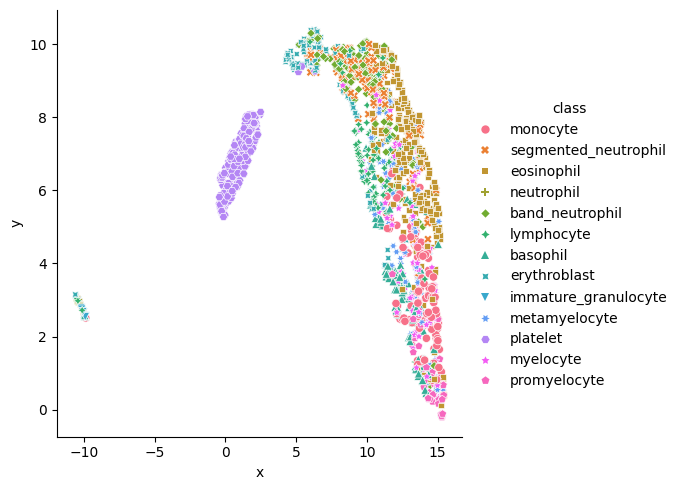

In [59]:
import seaborn as sns
import matplotlib.pyplot as plt

df_plot = df_emb.copy()

plt.figure(figsize=(12,16))
sns.relplot(
    data=df_plot,
    x="x", y="y", hue="class", style="class"
)
plt.show()

## K-NN 

In [37]:
device = "cpu"

data = {
    state: (
        torch.load(Path(embeddings_path) / state / 'embeddings.pt', map_location=device).numpy(),
        torch.load(Path(embeddings_path) / state / 'labels.pt', map_location=device).numpy() 
    )
        for state in os.listdir(embeddings_path)
}

In [41]:
X_train

array([[ 0.03252567, -0.41834426, -1.212866  , ..., -0.3115541 ,
        -1.1850222 , -0.42905423],
       [ 0.03252427, -0.41839254, -1.2128536 , ..., -0.3114274 ,
        -1.1849385 , -0.42911118],
       [ 0.03237896, -0.41827574, -1.2128359 , ..., -0.3119015 ,
        -1.1849673 , -0.42896074],
       ...,
       [ 0.03272272, -0.4184021 , -1.2128981 , ..., -0.3111342 ,
        -1.1850508 , -0.42924055],
       [ 0.03238999, -0.41839534, -1.2128155 , ..., -0.31166676,
        -1.1849028 , -0.42896682],
       [ 0.03275389, -0.4184576 , -1.2129229 , ..., -0.3111692 ,
        -1.1849792 , -0.42927974]], dtype=float32)

In [38]:
from sklearn.neighbors import KNeighborsClassifier

X_train, y_train = data["train"]
X_validation, y_validation = data["validation"]

In [39]:
knn = KNeighborsClassifier()
knn.fit(X_train, y_train)

KNeighborsClassifier()

In [40]:
from sklearn.metrics import classification_report

y_pred = knn.predict(X_validation)
print(classification_report(y_validation, y_pred))

              precision    recall  f1-score   support

           0       0.44      0.14      0.21        59
           1       0.34      0.64      0.45       122
           2       0.17      0.13      0.15       101
           3       0.58      0.57      0.57       142
           4       0.47      0.12      0.19       122
           5       0.77      0.86      0.81       312
           6       0.38      0.45      0.41       165
           7       0.75      0.60      0.67         5
           8       0.59      0.77      0.67       155
           9       0.97      1.00      0.99       235
          10       0.67      0.80      0.73        15
          11       0.26      0.24      0.25       163
          12       0.27      0.13      0.18       114

    accuracy                           0.56      1710
   macro avg       0.51      0.50      0.48      1710
weighted avg       0.55      0.56      0.54      1710



## RF based algorithm

In [50]:
from sklearn.ensemble import RandomForestClassifier

rf = RandomForestClassifier()
rf.fit(X_train, y_train)

RandomForestClassifier()

In [51]:
y_pred = rf.predict(X_validation)
print(classification_report(y_validation, y_pred))

              precision    recall  f1-score   support

           0       0.86      0.10      0.18        59
           1       0.57      0.50      0.53       122
           2       0.12      0.05      0.07       101
           3       0.62      0.57      0.59       142
           4       0.67      0.32      0.43       122
           5       0.73      0.89      0.80       312
           6       0.43      0.68      0.53       165
           7       0.80      0.80      0.80         5
           8       0.72      0.83      0.77       155
           9       1.00      1.00      1.00       235
          10       0.74      0.93      0.82        15
          11       0.28      0.40      0.33       163
          12       0.22      0.11      0.14       114

    accuracy                           0.61      1710
   macro avg       0.60      0.55      0.54      1710
weighted avg       0.60      0.61      0.58      1710



> Compared to the image that we cn see from the UMAP of the embeddings there is a coherence with the classes that are well of badly predicted :  
> platelets that are on their island have 100% acc, while myelocyte metamyelocyte that are in the pack are badly predicted